In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import *
#from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 300/300 [00:12<00:00, 24.61it/s]


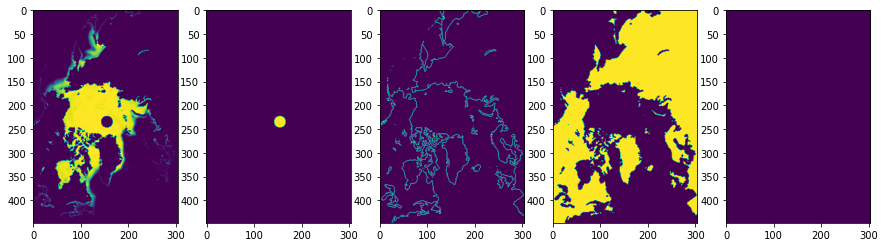

In [5]:
path = '/content/drive/MyDrive/해빙/data_v2/'
train_csv = pd.read_csv(path+'train_v2.csv') 
train_csv.head()
train_path = sorted(glob(path+'train_data_v2/*.npy'))
train_path = train_path[-25*12:]
#25년치
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)
train.shape

plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])


In [6]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)
train_month.shape



(12, 25, 448, 304, 5)

In [7]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp
train_month.shape

(12, 25, 480, 320, 5)

In [8]:
window_size = 5
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :,:,:])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :,:,:])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape, y_train.shape



((20, 12, 5, 480, 320, 5), (20, 12, 1, 480, 320, 5))

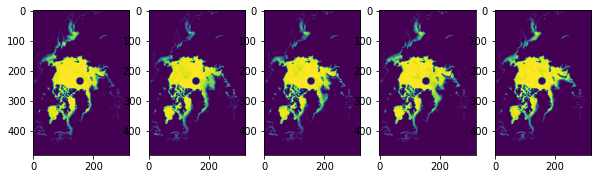

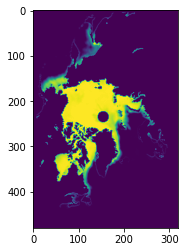

In [9]:
m = 1
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])


In [10]:
#stride = 32
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)


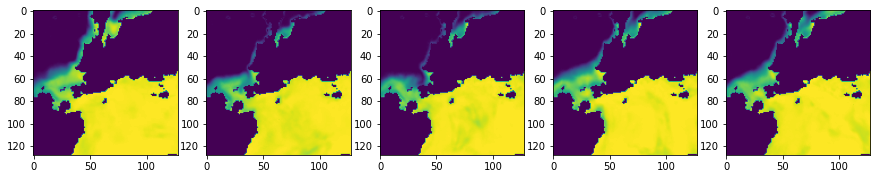

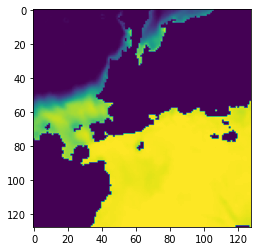

In [11]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])


In [12]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

BATCH_SIZE = 32


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [13]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape


(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [14]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape


(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [15]:
strategy = tf.distribute.get_strategy() 
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=4, activation='relu', padding='same', data_format='channels_last')(convLSTM)

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 6  150016    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 6  295168    
                             4)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 6  256  

In [16]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks_list)


Epoch 1/50
630/630 [==============================] - 507s 773ms/step - loss: 12.0670 - val_loss: 7.2857
Epoch 2/50
630/630 [==============================] - 487s 773ms/step - loss: 8.6656 - val_loss: 6.4582
Epoch 3/50
630/630 [==============================] - 487s 773ms/step - loss: 8.1144 - val_loss: 6.0164
Epoch 4/50
630/630 [==============================] - 487s 773ms/step - loss: 6.8822 - val_loss: 4.9362
Epoch 5/50
630/630 [==============================] - 487s 773ms/step - loss: 6.3336 - val_loss: 5.2694
Epoch 6/50
630/630 [==============================] - 487s 774ms/step - loss: 5.9617 - val_loss: 5.5005
Epoch 7/50
630/630 [==============================] - 487s 774ms/step - loss: 5.6984 - val_loss: 4.4959
Epoch 8/50
630/630 [==============================] - 487s 774ms/step - loss: 5.8096 - val_loss: 5.3133
Epoch 9/50
630/630 [==============================] - 487s 774ms/step - loss: 5.5553 - val_loss: 4.9248
Epoch 10/50
630/630 [==============================] - 487s 774

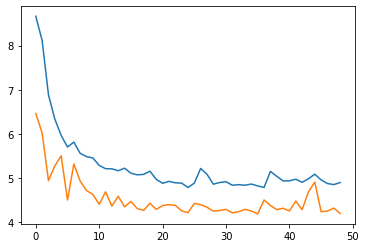

1/1 [==============================] - 1s 1s/step


In [17]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.show()
model = load_model('./models/convlstm_model.h5')
pred = model.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)


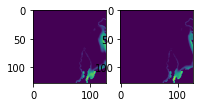

2.2878783


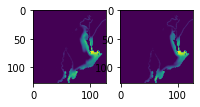

3.0411751


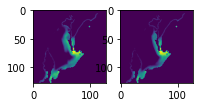

3.0652258


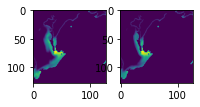

2.9450958


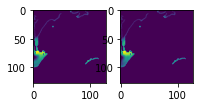

0.8877915


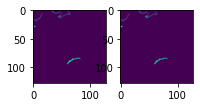

0.16916005


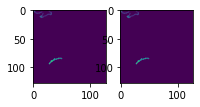

0.14133567


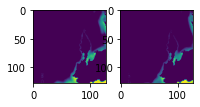

3.1246386


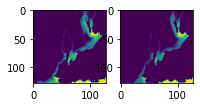

3.8706462


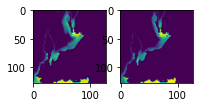

3.513752


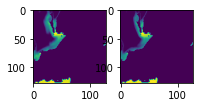

2.8323812


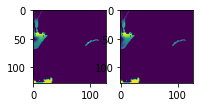

0.8465572


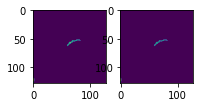

0.089836106


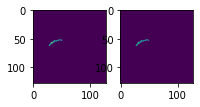

0.0795625


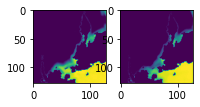

4.8157134


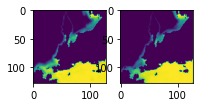

5.4302025


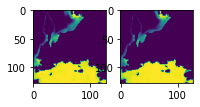

3.3385098


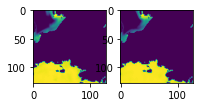

2.1630409


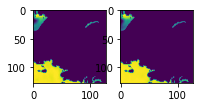

1.1343577


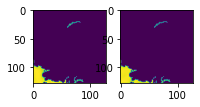

0.36408526


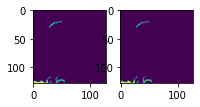

0.15646368


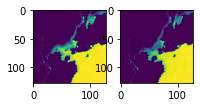

4.758195


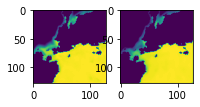

4.9471664


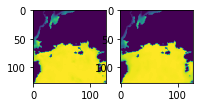

3.1998029


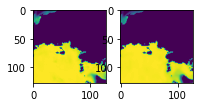

2.5440667


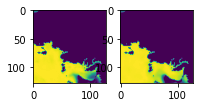

3.6120026


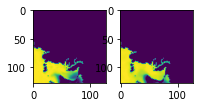

3.1985664


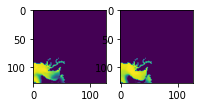

2.6417432


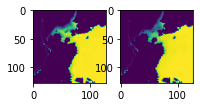

4.3949556


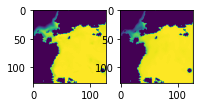

4.5526676


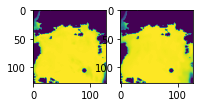

3.6966481


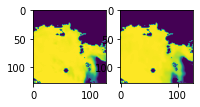

4.0492067


In [18]:
for i in range(BATCH_SIZE):
    plt.subplot(141)
    plt.imshow(next(iter(val_dataset))[1][i,0,:,:,0])
    plt.subplot(142)
    plt.imshow(pred[i,0,:,:,0])
    plt.show()
    print(np.mean(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0])))


In [19]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


In [20]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


  0%|          | 0/12 [00:00<?, ?it/s]

3/3 [==============================] - 1s 409ms/step


  8%|▊         | 1/12 [00:01<00:16,  1.54s/it]

3/3 [==============================] - 1s 265ms/step


 17%|█▋        | 2/12 [00:02<00:11,  1.10s/it]

3/3 [==============================] - 1s 264ms/step


 25%|██▌       | 3/12 [00:03<00:08,  1.04it/s]

3/3 [==============================] - 1s 265ms/step


 33%|███▎      | 4/12 [00:03<00:07,  1.11it/s]

3/3 [==============================] - 1s 265ms/step


 42%|████▏     | 5/12 [00:04<00:06,  1.16it/s]

3/3 [==============================] - 1s 265ms/step


 50%|█████     | 6/12 [00:05<00:05,  1.19it/s]

3/3 [==============================] - 1s 265ms/step


 58%|█████▊    | 7/12 [00:06<00:04,  1.21it/s]

3/3 [==============================] - 1s 265ms/step


 67%|██████▋   | 8/12 [00:07<00:03,  1.23it/s]

3/3 [==============================] - 1s 265ms/step


 75%|███████▌  | 9/12 [00:07<00:02,  1.23it/s]

3/3 [==============================] - 1s 265ms/step


 83%|████████▎ | 10/12 [00:08<00:01,  1.24it/s]

3/3 [==============================] - 1s 265ms/step


 92%|█████████▏| 11/12 [00:09<00:00,  1.24it/s]

3/3 [==============================] - 1s 265ms/step


100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


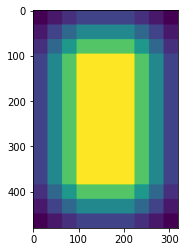

In [21]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones


plt.imshow(voting_mask)

results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)


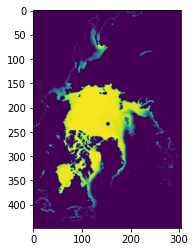

1 



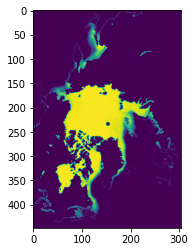

2 



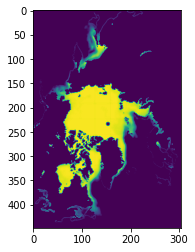

3 



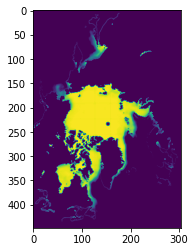

4 



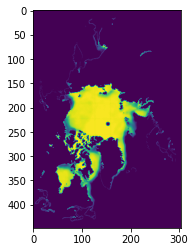

5 



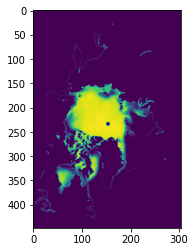

6 



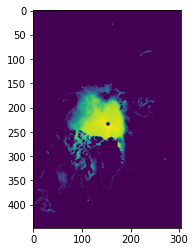

7 



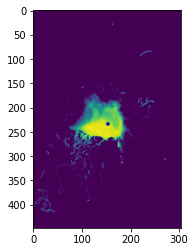

8 



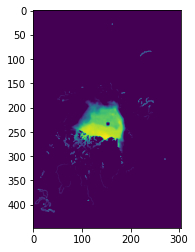

9 



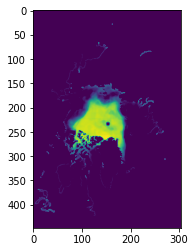

10 



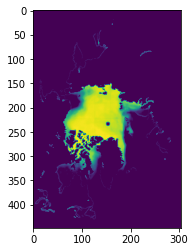

11 



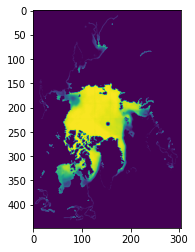

12 



In [22]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')
